In [ ]:
# A próxima célula deve incluir o token criado no Watson Studio (para poder salvar o arquivo result.csv)
# Vá em Informações Adicionais no notebook -> inserir token do projeto (na célula abaixo)

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='3e6fadcc-a919-4894-802b-db7032f67edf', project_access_token='p-19bfb32c9b5ec6c6ddecb2f10ee7c2fc2a65239d')
pc = project.project_context


## DESAFIO 6  (Maratona Behind the Code 2020) - IBM

## Proposta do desafio:

Criar um modelo que classifica o perfil de cada aluno para prever a categoria dos alunos futuros do LIT (O LIT é a plataforma digital de cursos da Saint Paul Escola de Negócios)

## Instalando bibliotecas

In [2]:
!pip install scikit-learn --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)


In [3]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.2.0)


In [4]:
!pip install imblearn --upgrade

Requirement already up-to-date: imblearn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.0)


## Download dos conjuntos de dados em formato .csv do GitHub

In [5]:
import pandas as pd
import numpy as np

In [6]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/training_dataset.csv
df_training_dataset = pd.read_csv(r'training_dataset.csv')
df_training_dataset.tail()

--2020-09-03 20:06:07--  https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/training_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1736600 (1.7M) [text/plain]
Saving to: ‘training_dataset.csv.13’

100%[======================================>] 1,736,600   --.-K/s   in 0.04s   

2020-09-03 20:06:08 (46.6 MB/s) - ‘training_dataset.csv.13’ saved [1736600/1736600]



,id,graduacao,universidade,profissao,organizacao,pretende_fazer_cursos_lit,interesse_mba_lit,importante_ter_certificado,horas_semanais_estudo,como_conheceu_lit,total_modulos,modulos_iniciados,modulos_finalizados,certificados,categoria
15852,620397030.0,Bacharelado,UFF,Outros,Borracha,0.0,0.0,1.0,8.0,NaN,10.0,NaN,NaN,NaN,perfil6
15853,229931283.0,Bacharelado,NaN,Advogado,NaN,0.0,0.0,1.0,7.0,Linkedin,42.0,17.0,15.0,NaN,perfil5
15854,480674907.0,Tecnólogo,UNIP,Sócio/Dono/Proprietário,NaN,0.0,NaN,1.0,7.0,Outros,30.0,9.0,8.0,0.0,perfil5
15855,559626807.0,SEM FORMAÇÃO,UNIVERSIDADE NOVE DE JULHO,Advogado,Estado,0.0,0.0,1.0,10.0,NaN,226.0,102.0,93.0,1.0,perfil1
15856,743652801.0,NaN,FGV-RJ,NaN,Siderurgica,1.0,1.0,1.0,9.0,Outros,125.0,98.0,97.0,1.0,perfil1


## Explorando os dados

In [7]:
# Checando informações
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15857 entries, 0 to 15856
Data columns (total 15 columns):
id                            13945 non-null float64
graduacao                     13950 non-null object
universidade                  13920 non-null object
profissao                     13977 non-null object
organizacao                   13961 non-null object
pretende_fazer_cursos_lit     13989 non-null float64
interesse_mba_lit             14003 non-null float64
importante_ter_certificado    13918 non-null float64
horas_semanais_estudo         13959 non-null float64
como_conheceu_lit             13915 non-null object
total_modulos                 13987 non-null float64
modulos_iniciados             14044 non-null float64
modulos_finalizados           13924 non-null float64
certificados                  13979 non-null float64
categoria                     15857 non-null object
dtypes: float64(9), object(6)
memory usage: 1.8+ MB


In [8]:
# Checando dados únicos
df_training_dataset.nunique()

id                            13945
graduacao                         6
universidade                     21
profissao                        12
organizacao                      11
pretende_fazer_cursos_lit         2
interesse_mba_lit                 2
importante_ter_certificado        1
horas_semanais_estudo             9
como_conheceu_lit                 9
total_modulos                   578
modulos_iniciados               372
modulos_finalizados             339
certificados                     23
categoria                         6
dtype: int64

In [9]:
# Removendo colunas indesejadas do dataset
df1 = df_training_dataset.drop(columns=['id','graduacao','universidade', 'organizacao', 'como_conheceu_lit', 'profissao', 'importante_ter_certificado', 'modulos_iniciados', 'interesse_mba_lit'], axis=1, inplace=False)

In [10]:
# Verificando as colunas restantes
df1.columns

Index(['pretende_fazer_cursos_lit', 'horas_semanais_estudo', 'total_modulos',
       'modulos_finalizados', 'certificados', 'categoria'],
      dtype='object')

## Balanceamento dos dados e split do dataframe em treino e teste para validação

In [11]:
# SMOTE para balanceamento do dataframe
# XGBoost para o modelo
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

xgb_model = XGBClassifier(objective='multi:logistic', n_jobs=2)
smote = SMOTE(n_jobs=2)

# Removendo as linhas nulas
df_training2 = df1.dropna()

In [13]:
# Definindo as features e o target para o modelo
features = df_training2[['pretende_fazer_cursos_lit', 'horas_semanais_estudo', 'total_modulos',
       'modulos_finalizados', 'certificados']]

target = df_training2['categoria']

In [14]:
# split e report da precisão
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

X_train, y_train = smote.fit_resample(X_train, y_train)

y_pred = xgb_model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     perfil1       0.81      0.84      0.83       249
     perfil2       0.88      0.86      0.87       465
     perfil3       0.85      0.79      0.82       125
     perfil4       0.82      0.79      0.81       187
     perfil5       0.84      0.85      0.84       203
     perfil6       0.84      0.86      0.85       455

    accuracy                           0.84      1684
   macro avg       0.84      0.83      0.84      1684
weighted avg       0.84      0.84      0.84      1684



### Analisando a qualidade do modelo através da matriz de confusão

In [15]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

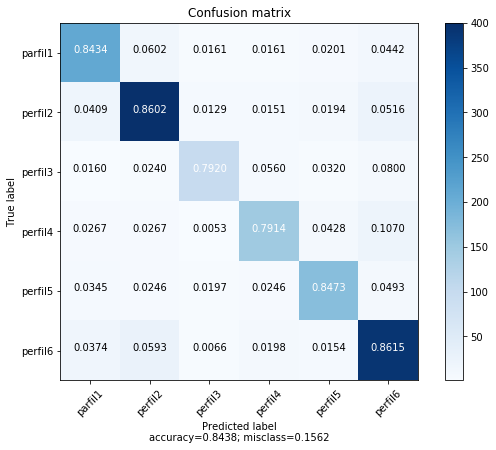

In [16]:
from sklearn.metrics import confusion_matrix


plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['parfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])

O modelo alcançou uma acurácia de 84% sobre as previsões, com pouca margem de erro, sigo para a aplicação na folha de respostas que é o dataframe que será usado para previsão com dados novos.

**Testei alguns modelos de classificação e a melhor acurácia apresentada foi a do XGBoost**

## Aplicando o modelo no dataframe "folha de respostas" para submissão

### Download da "folha de respostas"

In [17]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/to_be_scored.csv
df_to_be_scored = pd.read_csv(r'to_be_scored.csv')
df_to_be_scored.head()

--2020-09-03 20:06:13--  https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/to_be_scored.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96291 (94K) [text/plain]
Saving to: ‘to_be_scored.csv.12’

100%[======================================>] 96,291      --.-K/s   in 0.004s  

2020-09-03 20:06:13 (20.5 MB/s) - ‘to_be_scored.csv.12’ saved [96291/96291]



,id,graduacao,universidade,profissao,organizacao,pretende_fazer_cursos_lit,interesse_mba_lit,importante_ter_certificado,horas_semanais_estudo,como_conheceu_lit,total_modulos,modulos_iniciados,modulos_finalizados,certificados
0,648443203,Bacharelado,Unesp,Outros,Borracha,0,0,1,3,Saint Paul,58,3,2,0
1,423266690,Especialização,UNICAMP,SEM EXPERIÊNCIA,Eletrodomesticos,1,1,1,7,Mídia (revista/jornal/web),62,19,17,0
2,315097368,Bacharelado,UNICAMP,Engenheiro,Oleo e Gas,0,0,1,9,Google,36,3,1,0
3,911835279,Licenciatura,UNICAMP,Outros,Estado,1,1,1,9,Google,145,61,54,1
4,755852400,Especialização,FACULDADE ANHANGUERA,Engenheiro,Entretenimento,0,0,1,8,Minha empresa - benefício LITpass,33,33,29,0


## Processando os dados de teste no mesmo formato que os de treino

In [18]:
df_to_be_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
id                            1000 non-null int64
graduacao                     1000 non-null object
universidade                  1000 non-null object
profissao                     1000 non-null object
organizacao                   1000 non-null object
pretende_fazer_cursos_lit     1000 non-null int64
interesse_mba_lit             1000 non-null int64
importante_ter_certificado    1000 non-null int64
horas_semanais_estudo         1000 non-null int64
como_conheceu_lit             1000 non-null object
total_modulos                 1000 non-null int64
modulos_iniciados             1000 non-null int64
modulos_finalizados           1000 non-null int64
certificados                  1000 non-null int64
dtypes: int64(9), object(5)
memory usage: 109.5+ KB


In [19]:
df_to_be_scored_1 = df_to_be_scored.drop(columns=['id','graduacao','universidade', 'organizacao', 'como_conheceu_lit', 'profissao', 'importante_ter_certificado', 'modulos_iniciados', 'interesse_mba_lit'], axis=1, inplace=False)

In [20]:
df_training2[['pretende_fazer_cursos_lit','horas_semanais_estudo','total_modulos', 'modulos_finalizados', 'certificados', 'categoria']].columns

Index(['pretende_fazer_cursos_lit', 'horas_semanais_estudo', 'total_modulos',
       'modulos_finalizados', 'certificados', 'categoria'],
      dtype='object')

In [21]:
# Verificando se o modelo teste está igual ao de treino (devem estar na mesma posição ou vai dar erro)
# OBS: o dataframe do teste não contém o target
df_to_be_scored_1.columns

Index(['pretende_fazer_cursos_lit', 'horas_semanais_estudo', 'total_modulos',
       'modulos_finalizados', 'certificados'],
      dtype='object')

In [22]:
df_to_be_scored_2 = df_to_be_scored_1.dropna()

In [23]:
df_to_be_scored_2.columns

Index(['pretende_fazer_cursos_lit', 'horas_semanais_estudo', 'total_modulos',
       'modulos_finalizados', 'certificados'],
      dtype='object')

In [24]:
# Aplicando o modelo no teste
y_pred = xgb_model.predict(df_to_be_scored_2)

df_to_be_scored_2['target'] = y_pred
df_to_be_scored_2.head()

,pretende_fazer_cursos_lit,horas_semanais_estudo,total_modulos,modulos_finalizados,certificados,target
0,0,3,58,2,0,perfil6
1,1,7,62,17,0,perfil3
2,0,9,36,1,0,perfil6
3,1,9,145,54,1,perfil1
4,0,8,33,29,0,perfil2


### Salvando a submissão como um arquivo .csv

In [25]:
project.save_data(file_name="results.csv", data=df_to_be_scored_2.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'projetolit-donotdelete-pr-tnufwvi4lgzatw',
 'asset_id': '7ae3b420-49bc-4f8e-9ab3-9ca68bbc9f1e'}

# Atenção

# A execução da célula acima irá criar um novo "data asset" no seu projeto no Watson Studio.

# SE O TOKEN NÃO FOR ADICIONADO NA PRIMEIRA CÉLULA VAI DAR ERRO.